# Padalme GSO_st

SEOYEON CHOI  
2023-04-29

> edit

In [1]:
import itstgcnsnd
import torch
import itstgcnsnd.planner 

In [2]:
from torch_geometric_temporal.dataset import PedalMeDatasetLoader
loader2 = PedalMeDatasetLoader()

In [3]:
import numpy as np

In [4]:
from torch_geometric_temporal.nn.recurrent import GConvGRU
import copy
import torch_geometric_temporal
import torch.nn.functional as F

In [5]:
from rpy2.robjects.vectors import FloatVector
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri as rpyn
GNAR = importr('GNAR') # import GNAR 
#igraph = importr('igraph') # import igraph 
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [6]:
def flatten_weight(T,N,ws,wt):
    Is = np.eye(N,N)
    lst = [[0]*T for t in range(T)]
    for i in range(T):
        for j in range(T):
            if i==j: 
                lst[i][j] = ws 
            elif abs(i-j)==1:
                lst[i][j] = Is
            else:
                lst[i][j] = Is*0
    return np.concatenate([np.concatenate(l,axis=1) for l in lst],axis=0) # TN*TN matrix

def make_Psi(T,N,edge_index,edge_weight):
    wt = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                wt[i,j] = 0
            elif np.abs(i-j) <= 1 : 
                wt[i,j] = 1
    ws = np.zeros((N,N))
    for i in range(N):
        for j in range(edge_weight.shape[0]):
            if edge_index[0][j] == i :
                ws[i,edge_index[1][j]] = edge_weight[j]
    W = flatten_weight(T,N,ws,wt) # TN*TN matrix
    d = np.array(W.sum(axis=1))
    D = np.diag(d)
    L = np.array(np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d)))
    lamb, Psi = np.linalg.eigh(L)
    return Psi # TN*TN matrix

def trim(f,edge_index,edge_weight):
    f = np.array(f)
    if len(f.shape)==1: f = f.reshape(-1,1)
    T,N = f.shape # f = T*N matrix
    Psi = make_Psi(T,N,edge_index,edge_weight) # TN*TN matrix
    fbar = Psi.T @ f.reshape(-1,1) # TN*TN X TN*1 matrix = TN*1 matrix
    fbar_threshed = np.stack([ebayesthresh(FloatVector(fbar.reshape(-1,N)[:,i])) for i in range(N)],axis=1)
    fhat_flatten = Psi @ fbar_threshed.reshape(-1,1) # inverse dft 
    fhat = fhat_flatten.reshape(-1,N)
    return fhat

def update_from_freq_domain(signal, missing_index,edge_index,edge_weight):
    signal = np.array(signal)
    T,N = signal.shape 
    signal_trimed = trim(signal,edge_index,edge_weight)
    for i in range(N):
        try: 
            signal[missing_index[i],i] = signal_trimed[missing_index[i],i]
        except: 
            pass 
    return signal

class StgcnLearner:
    def __init__(self,train_dataset,dataset_name = None):
        self.train_dataset = train_dataset
        self.lags = torch.tensor(train_dataset.features).shape[-1]
        self.dataset_name = str(train_dataset) if dataset_name is None else dataset_name
        self.mindex= getattr(self.train_dataset,'mindex',None)
        self.mrate_eachnode = getattr(self.train_dataset,'mrate_eachnode',0)
        self.mrate_total = getattr(self.train_dataset,'mrate_total',0)
        self.mtype = getattr(self.train_dataset,'mtype',None)
        self.interpolation_method = getattr(self.train_dataset,'interpolation_method',None)
        self.method = 'STGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.model.train()
        for e in range(epoch):
            for t, snapshot in enumerate(self.train_dataset):
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = torch.mean((yt_hat-snapshot.y)**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # recording HP
        self.nof_filters = filters
        self.epochs = epoch+1
    def __call__(self,dataset):
        X = torch.tensor(dataset.features).float()
        y = torch.tensor(dataset.targets).float()
        yhat = torch.stack([self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr) for snapshot in dataset]).detach().squeeze().float()
        return {'X':X, 'y':y, 'yhat':yhat} 

class ITStgcnLearner(StgcnLearner):
    def __init__(self,train_dataset,dataset_name = None):
        super().__init__(train_dataset)
        self.method = 'IT-STGCN'
    def learn(self,filters=32,epoch=50):
        self.model = RecurrentGCN(node_features=self.lags, filters=filters)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.01)
        self.model.train()
        train_dataset_temp = copy.copy(self.train_dataset)
        for e in range(epoch):
            f,lags = convert_train_dataset(train_dataset_temp)
            f = update_from_freq_domain(f,self.mindex,self.train_dataset.edge_index,self.train_dataset.edge_weight)
            T,N = f.shape 
            data_dict_temp = {
                'edges':self.train_dataset.edge_index.T.tolist(), 
                'node_ids':{'node'+str(i):i for i in range(N)}, 
                'FX':f
            }
            train_dataset_temp = DatasetLoader(data_dict_temp).get_dataset(lags=self.lags)  
            for t, snapshot in enumerate(train_dataset_temp):
                yt_hat = self.model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
                cost = torch.mean((yt_hat-snapshot.y)**2)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
            print('{}/{}'.format(e+1,epoch),end='\r')
        # record
        self.nof_filters = filters
        self.epochs = epoch+1
        
        
def convert_train_dataset(train_dataset):
    lags = torch.tensor(train_dataset.features).shape[-1]
    f = torch.concat([train_dataset[0].x.T,torch.tensor(train_dataset.targets)],axis=0).numpy()
    return f,lags 


class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
    
class DatasetLoader(object):
    def __init__(self,data_dict):
        self._dataset = data_dict 
    def _get_edges(self):
        self._edges = np.array(self._dataset["edges"]).T

    def _get_edge_weights(self):
        self._edge_weights = np.ones(self._edges.shape[1])

    def _get_targets_and_features(self):
        stacked_target = np.array(self._dataset["FX"])
        self.features = [
            stacked_target[i : i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]
        self.targets = [
            stacked_target[i + self.lags, :].T
            for i in range(stacked_target.shape[0] - self.lags)
        ]

    def get_dataset(self, lags: int = 4) -> torch_geometric_temporal.signal.StaticGraphTemporalSignal:
        """Returning the Chickenpox Hungary data iterator.

        Args types:
            * **lags** *(int)* - The number of time lags.
        Return types:
            * **dataset** *(torch_geometric_temporal.signal.StaticGraphTemporalSignal)* - The Chickenpox Hungary dataset.
        """
        self.lags = lags
        self._get_edges()
        self._get_edge_weights()
        self._get_targets_and_features()
        dataset = torch_geometric_temporal.signal.StaticGraphTemporalSignal(
            self._edges, self._edge_weights, self.features, self.targets
        )
        return dataset
    
    
    
    

class Evaluator:
    def __init__(self,learner,train_dataset,test_dataset):
        self.learner = learner
        # self.learner.model.eval()
        try:self.learner.model.eval()
        except:pass
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.lags = self.learner.lags
        rslt_tr = self.learner(self.train_dataset) 
        rslt_test = self.learner(self.test_dataset)
        self.X_tr = rslt_tr['X']
        self.y_tr = rslt_tr['y']
        self.f_tr = torch.concat([self.train_dataset[0].x.T,self.y_tr],axis=0).float()
        self.yhat_tr = rslt_tr['yhat']
        self.fhat_tr = torch.concat([self.train_dataset[0].x.T,self.yhat_tr],axis=0).float()
        self.X_test = rslt_test['X']
        self.y_test = rslt_test['y']
        self.f_test = self.y_test 
        self.yhat_test = rslt_test['yhat']
        self.fhat_test = self.yhat_test
        self.f = torch.concat([self.f_tr,self.f_test],axis=0)
        self.fhat = torch.concat([self.fhat_tr,self.fhat_test],axis=0)
    def calculate_mse(self):
        test_base_mse_eachnode = ((self.y_test - self.y_test.mean(axis=0).reshape(-1,self.y_test.shape[-1]))**2).mean(axis=0).tolist()
        test_base_mse_total = ((self.y_test - self.y_test.mean(axis=0).reshape(-1,self.y_test.shape[-1]))**2).mean().item()
        train_mse_eachnode = ((self.y_tr-self.yhat_tr)**2).mean(axis=0).tolist()
        train_mse_total = ((self.y_tr-self.yhat_tr)**2).mean().item()
        test_mse_eachnode = ((self.y_test-self.yhat_test)**2).mean(axis=0).tolist()
        test_mse_total = ((self.y_test-self.yhat_test)**2).mean().item()
        self.mse = {'train': {'each_node': train_mse_eachnode, 'total': train_mse_total},
                    'test': {'each_node': test_mse_eachnode, 'total': test_mse_total},
                    'test(base)': {'each_node': test_base_mse_eachnode, 'total': test_base_mse_total},
                   }
    def _plot(self,*args,t=None,h=2.5,max_node=5,**kwargs):
        T,N = self.f.shape
        if t is None: t = range(T)
        fig = plt.figure()
        nof_axs = max(min(N,max_node),2)
        if min(N,max_node)<2: 
            print('max_node should be >=2')
        ax = fig.subplots(nof_axs ,1)
        for n in range(nof_axs):
            ax[n].plot(t,self.f[:,n],color='gray',*args,**kwargs)
            ax[n].set_title('node='+str(n))
        fig.set_figheight(nof_axs*h)
        fig.tight_layout()
        plt.close()
        return fig
    def plot(self,*args,t=None,h=2.5,**kwargs):
        self.calculate_mse()
        fig = self._plot(*args,t=None,h=2.5,**kwargs)
        ax = fig.get_axes()
        for i,a in enumerate(ax):
            _mse1= self.mse['train']['each_node'][i]
            _mse2= self.mse['test']['each_node'][i]
            _mse3= self.mse['test(base)']['each_node'][i]
            _mrate = self.learner.mrate_eachnode if set(dir(self.learner.mrate_eachnode)) & {'__getitem__'} == set() else self.learner.mrate_eachnode[i]
            _title = 'node{0}, mrate: {1:.2f}% \n mse(train) = {2:.2f}, mse(test) = {3:.2f}, mse(test_base) = {4:.2f}'.format(i,_mrate*100,_mse1,_mse2,_mse3)
            a.set_title(_title)
            _t1 = self.lags
            _t2 = self.yhat_tr.shape[0]+self.lags
            _t3 = len(self.f)
            a.plot(range(_t1,_t2),self.yhat_tr[:,i],label='fitted (train)',color='C0')
            a.plot(range(_t2,_t3),self.yhat_test[:,i],label='fitted (test)',color='C1')
            a.legend()
        _mse1= self.mse['train']['total']
        _mse2= self.mse['test']['total']
        _mse3= self.mse['test(base)']['total']
        _title =\
        'dataset: {0} \n method: {1} \n mrate: {2:.2f}% \n interpolation:{3} \n epochs={4} \n number of filters={5} \n lags = {6} \n mse(train) = {7:.2f}, mse(test) = {8:.2f}, mse(test_base) = {9:.2f} \n'.\
        format(self.learner.dataset_name,self.learner.method,self.learner.mrate_total*100,self.learner.interpolation_method,self.learner.epochs,self.learner.nof_filters,self.learner.lags,_mse1,_mse2,_mse3)
        fig.suptitle(_title)
        fig.tight_layout()
        return fig


In [70]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
loader1 = ChickenpoxDatasetLoader()

In [79]:
a = loader2.get_dataset(lags=1)

In [87]:
train_dataset, test_dataset = torch_geometric_temporal.signal.temporal_signal_split(a, train_ratio=0.8)

In [88]:
mindex = itstgcnsnd.rand_mindex(train_dataset,mrate=0.9)
dataset_miss = itstgcnsnd.miss(train_dataset,mindex,mtype='rand')
dataset_padded = itstgcnsnd.padding(dataset_miss,imputation_method='linear') # padding(train_dataset_miss,method='linear'와 같음)

In [89]:
lrnr = ITStgcnLearner(dataset_padded)

In [90]:
lrnr.learn(epoch=5)

5/5

In [91]:
ev = Evaluator(lrnr,train_dataset,test_dataset)

In [92]:
import matplotlib.pyplot as plt


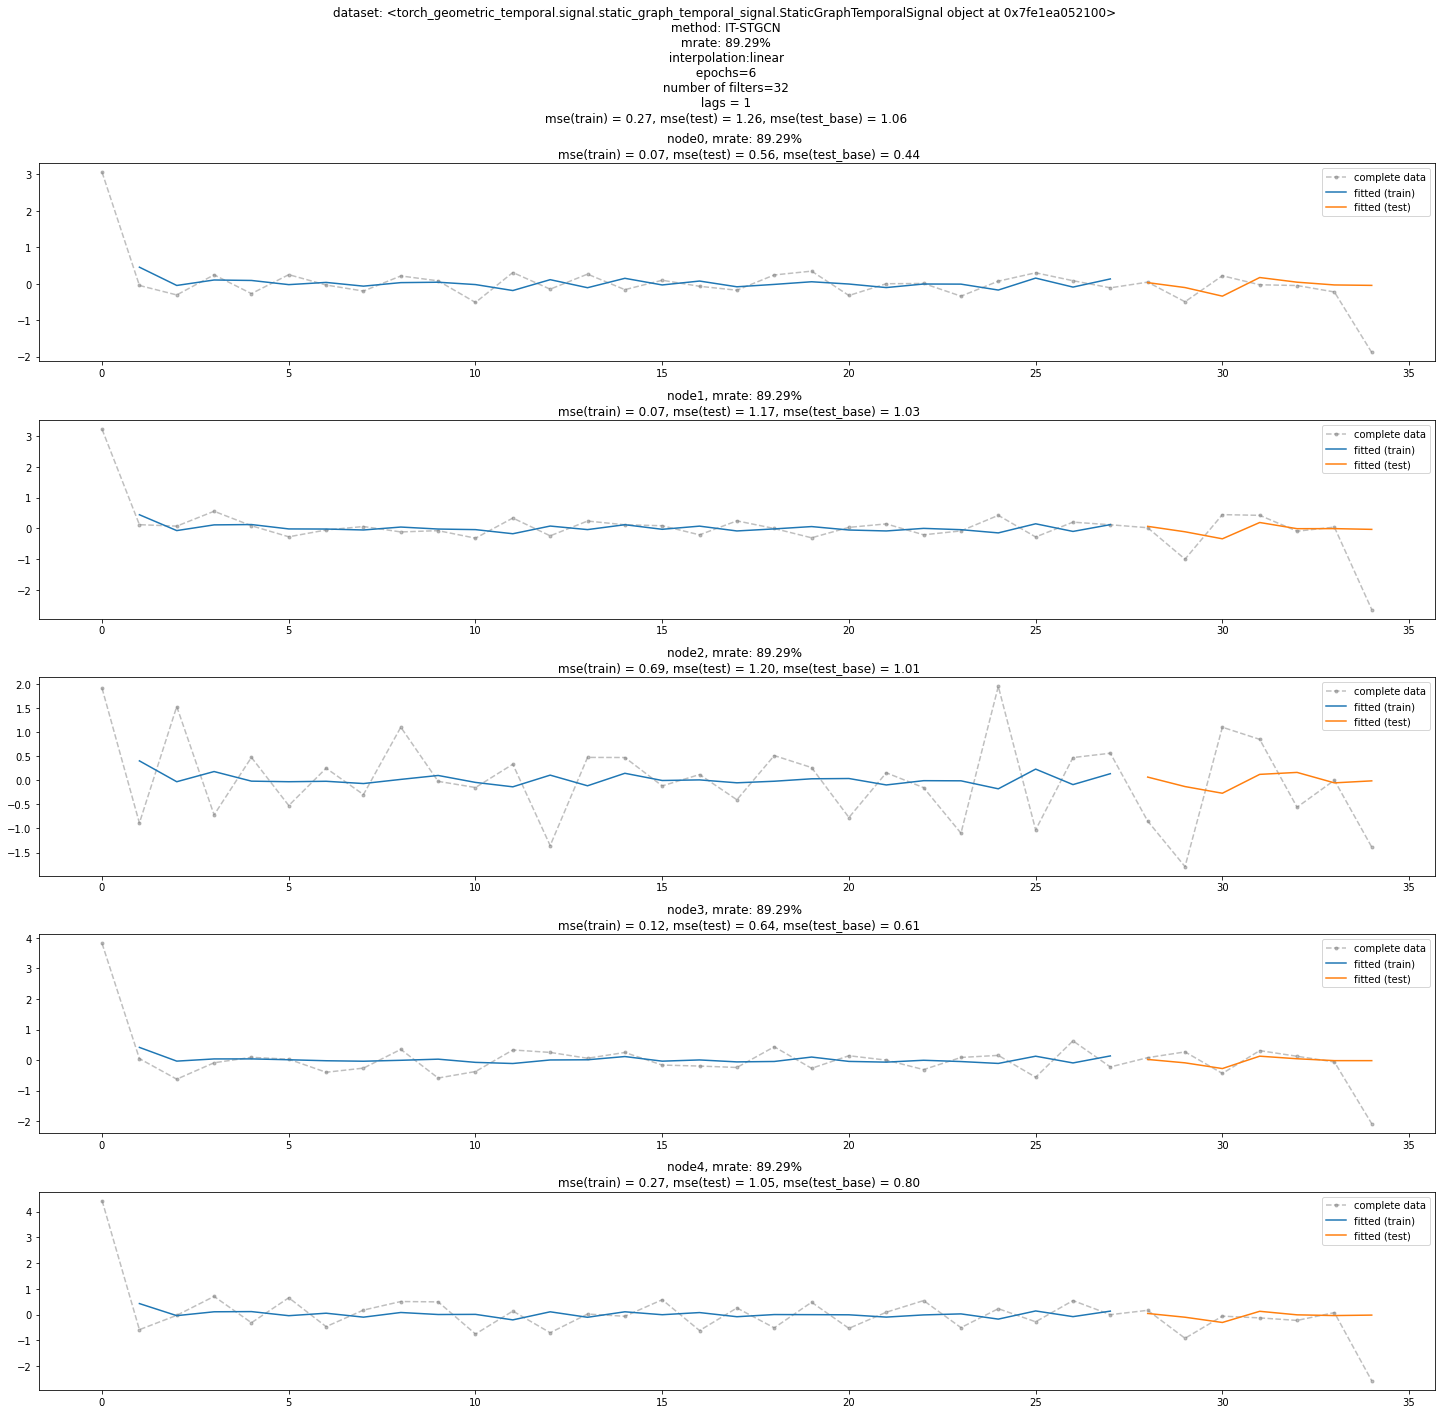

In [99]:
fig = ev.plot('--.',h=5,max_node=5,label='complete data',alpha=0.5) 
fig.set_figwidth(20)
fig.set_figheight(20)
fig.tight_layout()
fig

## random

In [10]:
plans_stgcn_rand = {
    'max_iteration': 30, 
    'method': ['STGCN', 'IT-STGCN'], 
    'mrate': [0.3,0.6],
    'lags': [4], 
    'nof_filters': [12], 
    'inter_method': ['linear','nearest'],
    'epoch': [50]
}

In [11]:
plnr = itstgcnsnd.planner.PLNR_STGCN_RAND(plans_stgcn_rand,loader2,dataset_name='pedalme')

In [12]:
plnr.simulate()

1/30 is done
2/30 is done
3/30 is done
4/30 is done
5/30 is done
6/30 is done
7/30 is done
8/30 is done
9/30 is done
10/30 is done
11/30 is done
12/30 is done
13/30 is done
14/30 is done
15/30 is done
16/30 is done
17/30 is done
18/30 is done
19/30 is done
20/30 is done
21/30 is done
22/30 is done
23/30 is done
24/30 is done
25/30 is done
26/30 is done
27/30 is done
28/30 is done
29/30 is done
30/30 is done
All results are stored in ./simulation_results/2023-07-02_07-01-12.csv

## block

In [13]:
my_list = [[] for _ in range(15)] #pedalme
another_list = list(range(10,25))
my_list[1] = another_list
my_list[3] = another_list
my_list[4] = another_list
my_list[5] = another_list
another_list = list(range(5,20))
my_list[7] = another_list
my_list[9] = another_list
my_list[10] = another_list
my_list[11] = another_list
mindex = my_list

In [14]:
# mindex= [[],[],[],list(range(50,150)),[]]  # node 1
# mindex= [list(range(10,100)),[],list(range(50,80)),[],[]] # node 2
# mindex= [list(range(10,100)),[],list(range(50,80)),list(range(50,150)),[]] # node3
plans_stgcn_block = {
    'max_iteration': 30, 
    'method': ['STGCN', 'IT-STGCN'], 
    'mindex': [mindex],
    'lags': [4], 
    'nof_filters': [12], 
    'inter_method': ['linear','nearest'],
    'epoch': [50]
}

In [15]:
plnr = itstgcnsnd.planner.PLNR_STGCN_MANUAL(plans_stgcn_block,loader2,dataset_name='pedalme')
plnr.simulate(mindex=mindex,mtype='block')

1/30 is done
2/30 is done
3/30 is done
4/30 is done
5/30 is done
6/30 is done
7/30 is done
8/30 is done
9/30 is done
10/30 is done
11/30 is done
12/30 is done
13/30 is done
14/30 is done
15/30 is done
16/30 is done
17/30 is done
18/30 is done
19/30 is done
20/30 is done
21/30 is done
22/30 is done
23/30 is done
24/30 is done
25/30 is done
26/30 is done
27/30 is done
28/30 is done
29/30 is done
30/30 is done
All results are stored in ./simulation_results/2023-07-02_07-19-21.csv

In [16]:
# df1 = pd.read_csv('./simulation_results/2023-04-13_20-37-59.csv')

In [14]:
# data = pd.concat([df1],axis=0);data